In [1]:
%matplotlib inline
import numpy as np
import keras
import keras.backend as K
from functools import reduce

import matplotlib.pyplot as plt

from keras.models         import Sequential
from keras.models         import Model
from keras.layers         import Dense
from keras.layers         import Convolution2D
from keras.layers         import AveragePooling2D
from keras.layers         import MaxPooling2D
from keras.layers         import UpSampling2D
from keras.layers         import Reshape
from keras.layers         import Flatten
from keras.metrics        import mse
from keras.optimizers     import Adam
from keras.utils.np_utils import to_categorical

path_to_fashion_mnist = '../../datasets/fashion-mnist/'

import sys
sys.path.insert(0, path_to_fashion_mnist)
from utils import mnist_reader

Using TensorFlow backend.


We first define the number of numbers that we will use to encode images.

In [2]:
encoding_size = 30
batch_size    = 64

We then loan, format and normalize the fashion MNIST dataset from [Zalando Research](https://github.com/zalandoresearch/fashion-mnist).

In [3]:
X_train, y_train = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 'train')
X_train          = X_train.reshape(-1, 28, 28, 1)
X_train          = (X_train - X_train.mean()) / X_train.std()
y_train          = to_categorical(y_train)

We now build the encoder which will play the role of the compressor. This encoder uses convolution and average pooling layers with a single fully connected layer at the end to create a code of length `encoding_size`.

In [4]:
encoder = Sequential([
    Convolution2D(32, 3, padding = 'same', input_shape = (28, 28, 1), activation = 'relu'),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),    
    AveragePooling2D(),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),    
    Flatten(),
    Dense(encoding_size, activation = 'tanh')
])

Then, we build the decoder which will play the role of the decompressor. The first layer of the network contains 49 nodes as we want to reshape its output to a 7x7 matrix and then upsample it twice to reach the 28x28 original image size.

In [5]:
decoder = Sequential([
    Dense(49, input_shape = (encoding_size,), activation = 'relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    Convolution2D(1, 3, padding = 'same', activation = 'tanh')
])

The autoencoder network is just the encoder and the decoder in sequence.

In [6]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(Adam(1e-4), loss = 'mse')

Now we want to create the "perceptual" part of this network. 

This kind of loss is used to deal with the fact that autoencoders trained with mean squared error loss tend to produce blurry images. The idea is, instead of focusing the attention of the autoencoder on every pixel value, we compute the MSE between the results of a convolution filter of a classifier neural network trained on this dataset. Informally, this architecture sets the goal of the autoencoder to produce images that contains the same material as the original one, which can be rephrased as producing an image that activates the same neurons of a classifier as the original one.

First, we create the classifier network.

In [7]:
classifier = Sequential([
    Convolution2D(32, 3, padding = 'same', activation = 'relu', input_shape = (28, 28, 1)),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    Flatten(),
    Dense(10,  activation = 'softmax')
])
classifier.compile(Adam(1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Then, we chose a convolution layer of this network as "perceptual target" and create a new network that outputs the results of this layer. 

In [8]:
last_convolution_layer = classifier.layers[6]
perceptual_part        = Model(classifier.input, last_convolution_layer.output)

Now, we train the classifier to recognize clothes as well as possible.

In [9]:
classifier_fit_params = {
    'x'              : X_train,
    'y'              : y_train,
    'epochs'         : 50,
    'batch_size'     : batch_size,
}

In [10]:
classifier.fit(**classifier_fit_params)

Epoch 1/50
60000/60000 [==============================] - 43s - loss: 0.6513 - acc: 0.7706    
Epoch 2/50
60000/60000 [==============================] - 38s - loss: 0.4109 - acc: 0.8518    
Epoch 3/50
60000/60000 [==============================] - 37s - loss: 0.3611 - acc: 0.8697    
Epoch 4/50
60000/60000 [==============================] - 37s - loss: 0.3274 - acc: 0.8822    
Epoch 5/50
60000/60000 [==============================] - 38s - loss: 0.3049 - acc: 0.8906    
Epoch 6/50
60000/60000 [==============================] - 38s - loss: 0.2855 - acc: 0.8983    
Epoch 7/50
60000/60000 [==============================] - 38s - loss: 0.2698 - acc: 0.9036    
Epoch 8/50
60000/60000 [==============================] - 38s - loss: 0.2576 - acc: 0.9070    
Epoch 9/50
60000/60000 [==============================] - 40s - loss: 0.2447 - acc: 0.9120    
Epoch 10/50
60000/60000 [==============================] - 39s - loss: 0.2336 - acc: 0.9145    
Epoch 11/50
60000/60000 [========================

In [11]:
classifier.save_weights('../models/classifier.h5')

In [12]:
classifier.load_weights('../models/classifier.h5')

Now that the classifier is trained, we freeze it. As we will use it as scoring mechanism, we do not want the optimizer to decrease the loss of the network by modifying the function used to compute it.

In [13]:
classifier.trainable = False
for layer in classifier.layers:
    layer.trainable = False

The perceptual model is the concatenation of the autoencoder and the perceptual loss network.

In [14]:
perceptual_model = Sequential([
    autoencoder,
    perceptual_part
])
perceptual_model.compile(Adam(1e-4), loss = 'mse')

Our full perceptual model does not compute the identity, it compute the image of the output of the autoencoder through the convolution of the classifier network. The target that we want to approximate is then the image of the training set by the convolutions of the classifier network.

In [15]:
y_train_perceptual = perceptual_part.predict(X_train, batch_size = batch_size)

We now train the full perceptual model.

In [16]:
perceptual_model_fit_params = {
    'x'         : X_train,
    'y'         : y_train_perceptual,
    'batch_size': batch_size,
    'epochs'    : 50
}

In [17]:
perceptual_model.fit(**perceptual_model_fit_params)

Epoch 1/50
60000/60000 [==============================] - 142s - loss: 1.9959   
Epoch 2/50
60000/60000 [==============================] - 139s - loss: 1.0672   
Epoch 3/50
60000/60000 [==============================] - 138s - loss: 0.9044   
Epoch 4/50
60000/60000 [==============================] - 138s - loss: 0.8216   
Epoch 5/50
60000/60000 [==============================] - 138s - loss: 0.7673   
Epoch 6/50
60000/60000 [==============================] - 140s - loss: 0.7262   
Epoch 7/50
60000/60000 [==============================] - 144s - loss: 0.6941   
Epoch 8/50
60000/60000 [==============================] - 139s - loss: 0.6671   
Epoch 9/50
60000/60000 [==============================] - 139s - loss: 0.6434   
Epoch 10/50
60000/60000 [==============================] - 139s - loss: 0.6247   
Epoch 11/50
60000/60000 [==============================] - 139s - loss: 0.6061   
Epoch 12/50
60000/60000 [==============================] - 140s - loss: 0.5916   
Epoch 13/50
60000/60000 [

In [18]:
perceptual_model.save_weights('../models/perceptual_model.h5')

In [19]:
perceptual_model.load_weights('../models/perceptual_model.h5')

And now we visualize a few results. Original pictures are in the first 4 columns and their corresponding image by the autoencoder are in the last 4 columns.

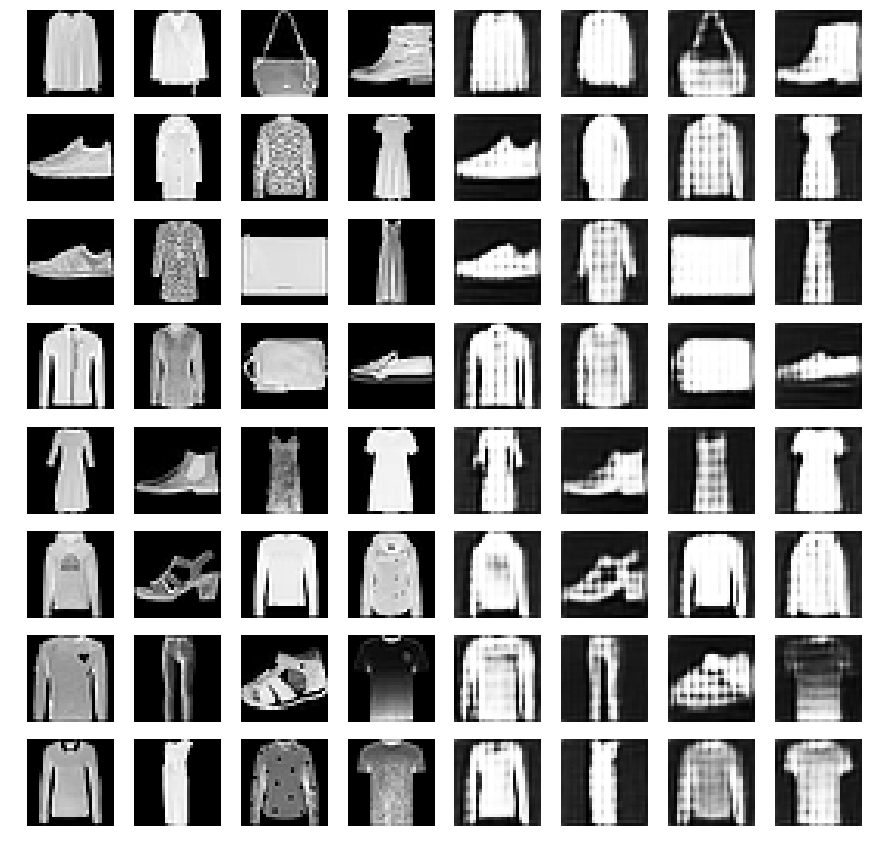

In [20]:
n_cols = 8
n_rows = 8
imgs   = np.random.permutation(X_train)[:n_cols * n_rows // 2]
preds  = autoencoder.predict(imgs)

plt.figure(figsize = (15, 15))
for i in range(n_rows):
    for j in range(n_cols):
        plot_idx = n_cols * i + j + 1
        if j < n_cols / 2:
            idx   = int(n_cols / 2 * i + j)
            image = imgs[idx]
        else:
            idx   = int(n_cols / 2 * i + j - n_cols / 2)
            image = preds[idx]
            
        plt.subplot(n_rows, n_cols, plot_idx)
        plt.imshow(image.squeeze(), cmap = 'gray')
        plt.axis('off')